In [1]:
from PARCv2 import PARCv2
from Differentiator.Advection import Advection
from Differentiator.Diffusion import Diffusion
from Differentiator.Differentiator import Differentiator
from Differentiator.FiniteDifference import FiniteDifference
from Integrator.Integrator import Integrator
from Integrator.Integrator import Poisson
from Integrator.RK4 import RK4

In [2]:
import torch
from torchmetrics.functional.image import image_gradients
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

### Finite difference testing

In [3]:
image = torch.arange(0, 1*1*5*5, dtype=torch.float32).to("cuda")
image = torch.reshape(image, (1, 1, 5, 5))
dy, dx = image_gradients(image)
dy[0, 0, :, :]

tensor([[5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [4]:
dx[0, 0, :, :]

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]], device='cuda:0')

In [5]:
right_diff = FiniteDifference(padding_mode="replicate")
dy, dx = right_diff(image)
dy[0, 0, :, :]

tensor([[5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [6]:
dx[0, 0, :, :]

tensor([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.]], device='cuda:0')

In [7]:
summary(right_diff, (8, 1, 5, 5))

Layer (type:depth-idx)                   Output Shape              Param #
FiniteDifference                         [8, 1, 5, 5]              --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Advection testing

In [8]:
adv = Advection(right_diff)

In [9]:
data = np.load("/project/vil_baek/data/physics/transport_eqn_square/transport_eqn_square_64_1.00_8.00_8.00_1.00_2.00_8.00_120_0.10.npy")
adv_gt = (data[1, :, :, 0] - data[0, :, :, 0])/0.1

In [10]:
state_var = torch.permute(torch.tensor(data[0:1, :, :, 0:1], dtype=torch.float32), (0, 3, 1, 2)).cuda()
vel_var = torch.permute(torch.tensor(data[0:1, :, :, 1:], dtype=torch.float32), (0, 3, 1, 2)).cuda()
adv_parc = adv(state_var, vel_var)

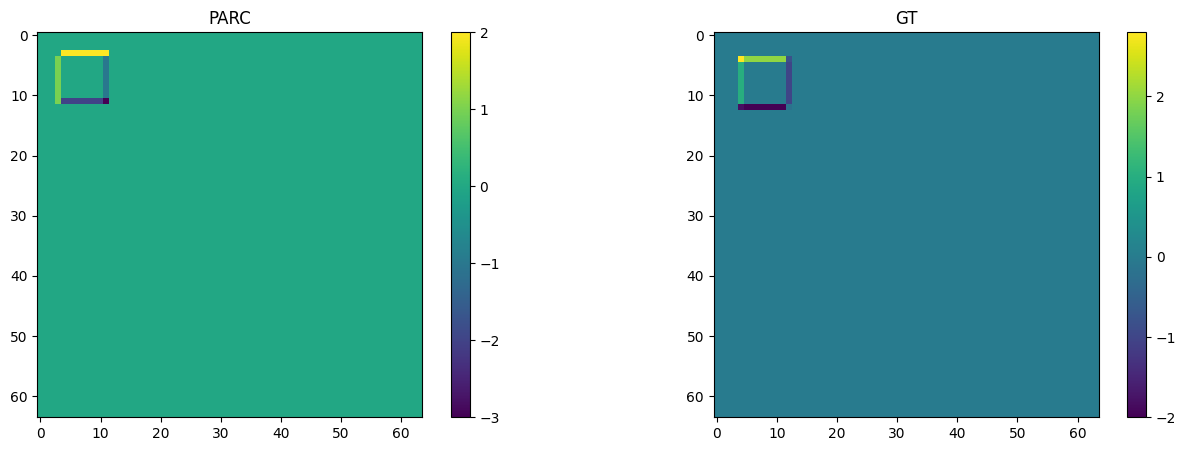

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
im0 = ax0.imshow(adv_parc.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
plt.colorbar(im0)
im1 = ax1.imshow(-adv_gt)
ax1.set_title("GT")
plt.colorbar(im1)

In [12]:
summary(adv, [(8, 1, 64, 128), (8,2, 64, 128)])

Layer (type:depth-idx)                   Output Shape              Param #
Advection                                [8, 1, 64, 128]           --
├─FiniteDifference: 1-1                  [8, 1, 64, 128]           --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.79
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.79

### Diffusion testing

In [13]:
x, y = np.linspace(-1.0, 1.0, 64), np.linspace(-1.0, 1.0, 64)
xx, yy = np.meshgrid(x, y, indexing='xy')
data = (xx**2.0)*(yy**3.0)
lap_gt = 2.0 * (yy**3.0) + (xx**2.0)*(6.0*yy)

In [14]:
dif = Diffusion(right_diff)
lap_parc = dif(torch.tensor(data.reshape(1, 1, 64, 64), dtype=torch.float32, device="cuda"))

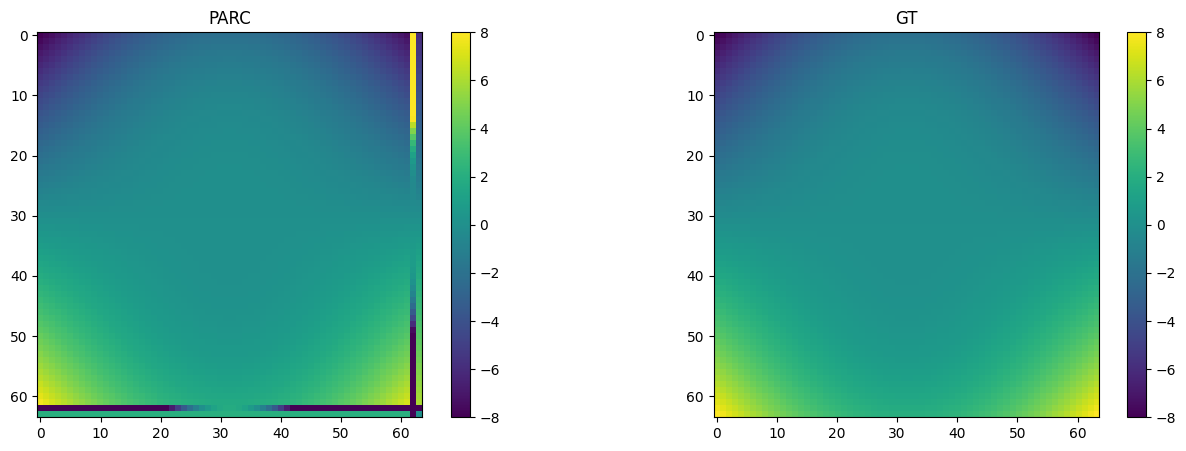

In [22]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
im0 = ax0.imshow(lap_parc.detach().cpu().numpy()[0, 0, :, :]*32*32, vmin=-8.0, vmax=8.0)
ax0.set_title("PARC")
plt.colorbar(im0)
im1 = ax1.imshow(lap_gt)
ax1.set_title("GT")
plt.colorbar(im1)

### Poisson testing

In [16]:
x, y = np.linspace(-1.0, 1.0, 64), np.linspace(-1.0, 1.0, 64)
xx, yy = np.meshgrid(x, y, indexing='xy')
vec_x = (xx**2.0)*(yy**3.0)
vec_y = (xx**4.0)*(yy**5.0)
vec = torch.cat([torch.tensor(vec_x.reshape(1, 1, 64, 64), dtype=torch.float), torch.tensor(vec_y.reshape(1, 1, 64, 64), dtype=torch.float)], 1)
x_dx, x_dy = 2.0*xx*(yy**3.0), (xx**2.0)*3.0*(yy**2.0)
y_dx, y_dy = 4.0*(xx**3.0)*(yy**5.0), (xx**4.0)*5.0*(yy*4.0)

In [17]:
poi = Poisson(right_diff)
x_dx2, y_dy2, x_dxy_dy = poi(vec.cuda())

Text(0.5, 1.0, 'GT')

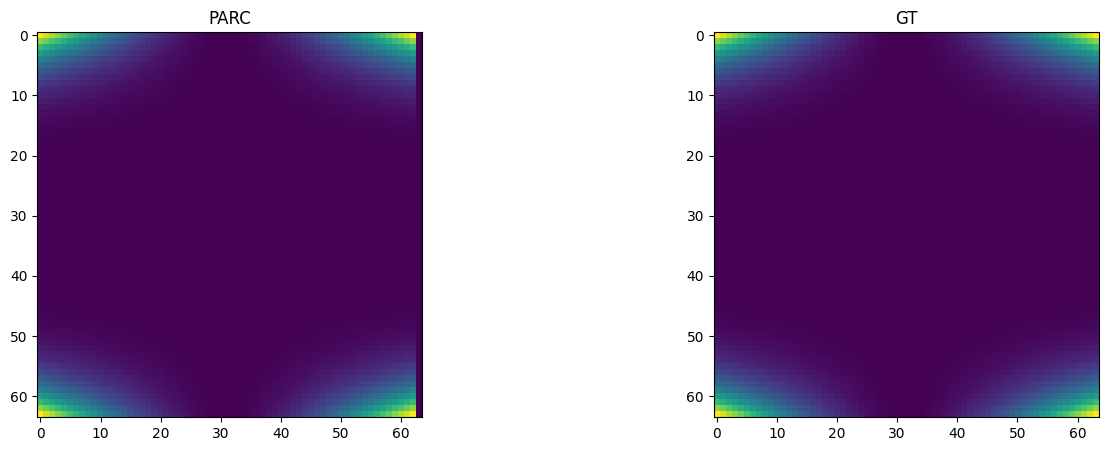

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(x_dx2.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
ax1.imshow(x_dx*x_dx)
ax1.set_title("GT")

Text(0.5, 1.0, 'GT')

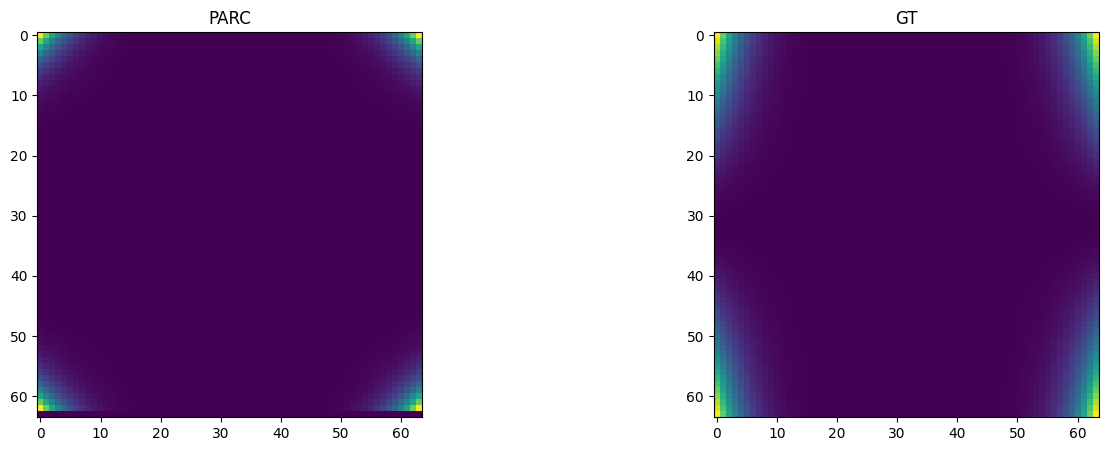

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(y_dy2.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
ax1.imshow(y_dy*y_dy)
ax1.set_title("GT")

Text(0.5, 1.0, 'GT')

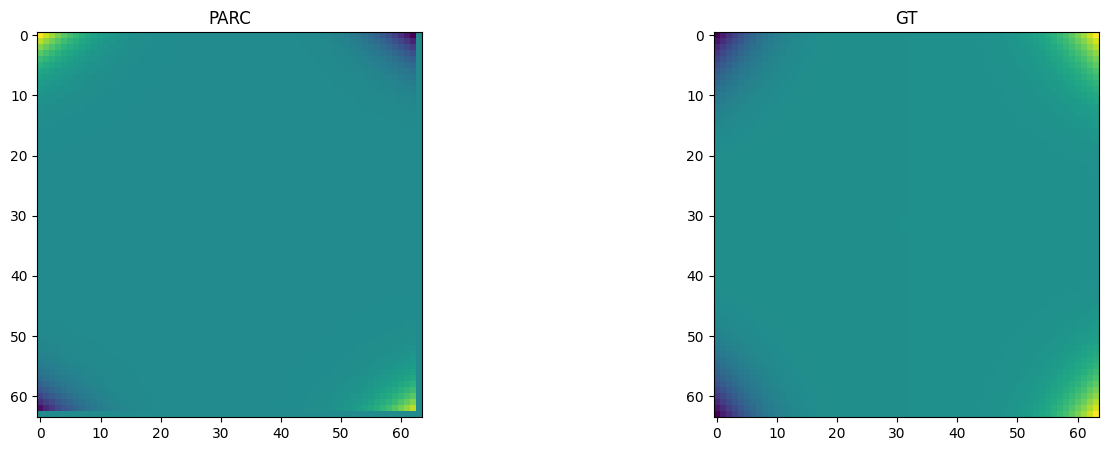

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(x_dxy_dy.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
ax1.imshow(x_dx*y_dy)
ax1.set_title("GT")